# Hillslope diffusion
Subaerial slope diffusion can be modeled with the diffusion equation.

$$
\frac{\partial h}{\partial t} = \frac{\partial}{\partial x} \left(-q \right)
$$

$$
q = -K \frac{\partial h}{\partial x}
$$

where $q$ is the flux and $K$ is the subaerial hillslope diffusion. For now, we will consider $K$ to be a constant value for the whole domain.

## Temporal discretization
### Implicit

$$
\frac{h^{t+1} - h^t}{\Delta t} = \frac{\partial}{\partial x} \left(K \frac{\partial h^{t+1}}{\partial x} \right)
$$

Since $h^{t+1}$ depends on its spatial derivative, rearrangement of the previous equation leads to a system of linear equations $A x = b$, where $A$ is a sparse-matrix, and $x$ and $b$ are column vectors. This temporal discretization is usually rather stable, however building the sparse-matrix $A$ and solving the linear system of equations is usually computationally rather expensive.

### Explicit

$$
\frac{h^{t+1} - h^t}{\Delta t} = \frac{\partial}{\partial x} \left(K \frac{\partial h^t}{\partial x} \right)
$$

which leads to

$$
h^{t+1} = h^t + \Delta t  \frac{\partial}{\partial x} \left(K \frac{\partial h^t}{\partial x} \right)
$$

Solving the previous equation straightforward as it is matrix-free. This means that it does not require to build a sparse matrix for the left-hand-side and we do not have to do a linear solve. This is nice because it is easy to implement and computationally efficient; however, this introduces limiations on the maximum time step allowed, whose upper bound if given by the CFL condition

$$
\frac{K \Delta t}{\Delta x}<C_{max}
$$

where

$$
C_{max}\leq 1
$$

## Spatial discretization

The spatial derivatives can be discretization with different methods: Finite Differences, Finite Elements, Finite Volumes, etc. In this workshop we will discretize the equations with Finite Differences with a staggered grid.

<p align="center">
<img src="../figs/2Dgrid.png" alt="drawing" width="300"/>
</p>

### Explicit

$$
q_{i+\frac{1}{2}} = -K \frac{h_{i+1}^t - h_{i}^t}{\Delta x}
$$

$$
h^{t+1}_i = h^t_i - \Delta t \frac{q_{i+\frac{1}{2}} - q_{i-\frac{1}{2}}}{\Delta x}
$$

# 💾 Time to program 💾
We will first implement a simple explicit solver for hillslope diffusion
We will start by defining the geometry:

In [1]:
n       = 128
L       = 50e3  # length of the topography profile
x       = LinRange(0, L, n)
y       = LinRange(0, L, n)
dx      = x[2] - x[1]
dy      = y[2] - y[1]
X       = [x for x in x, y in y]
Y       = [y for x in x, y in y]
h       = zeros(n, n)
ind     = @. (20e3 ≤ X ≤ 30e3) && (20e3 ≤ Y ≤ 30e3)
h[ind] .= 500

676-element view(::Vector{Float64}, [6580, 6581, 6582, 6583, 6584, 6585, 6586, 6587, 6588, 6589  …  9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805]) with eltype Float64:
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0
   ⋮
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0
 500.0

Note that the topography is rather arbitrary and we could use any other profile. Anyhow, we can visualise it with `GLMakie.jl` (or `CairoMakie.jl`)

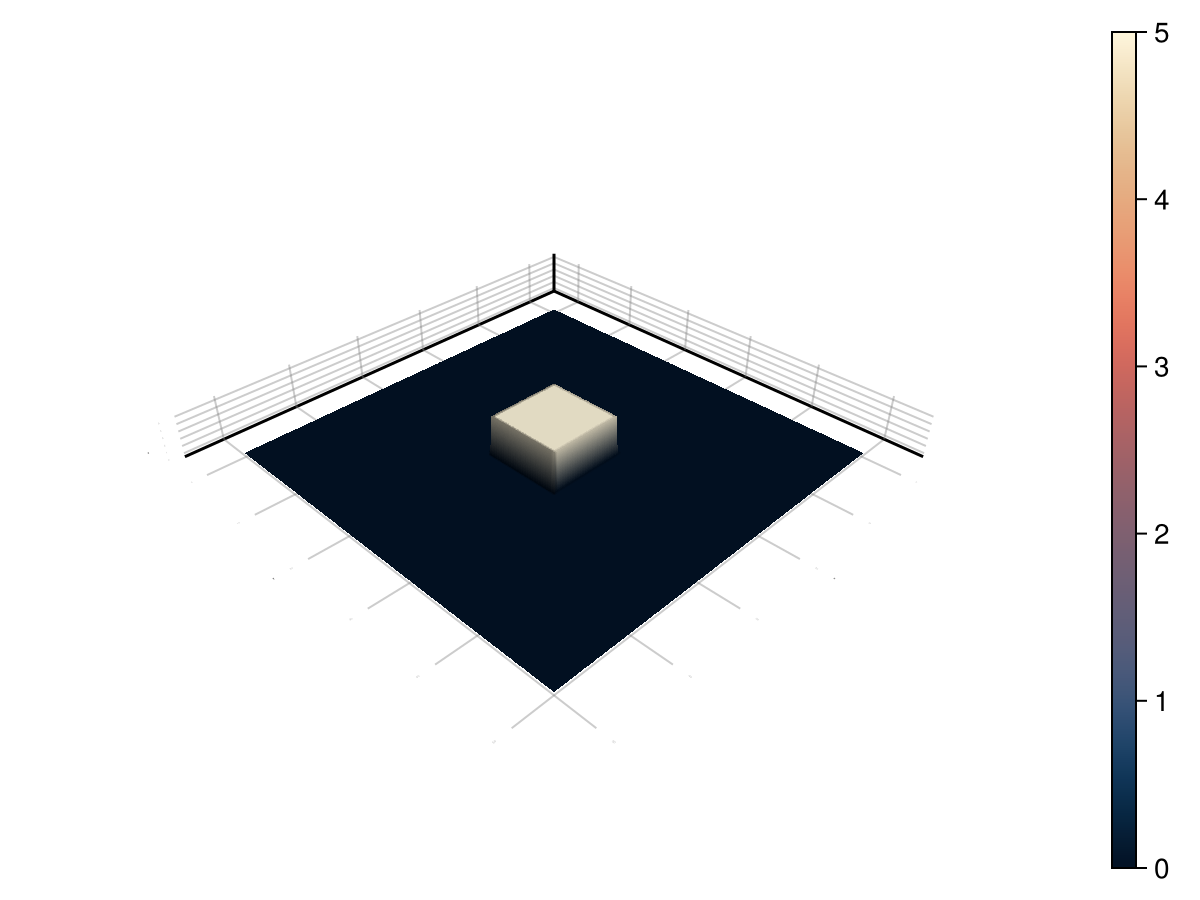

In [2]:
using CairoMakie
fig, ax, m = surface(x ./ 1e3, y ./ 1e3, h./1e2,colormap=:lipari)
Colorbar(fig[1,2], m)
fig

🔔 **Optional** : load a topography file using GeophysicalModelGenerator.jl and GMT

In [3]:
using GeophysicalModelGenerator, GMT
using Interpolations, LinearAlgebra

Since we are in France, let's import the topography of the Montblanc from the GMT's server and extract 2D array from the data structure

In [4]:
topography_GMT = import_topo([6.35, 7.35, 45.35, 46.35], file="@earth_relief_03s")
surf = topography_GMT.depth.val[:,:,1]

1201×1201 Matrix{Float64}:
 1.535  1.522  1.51   1.491  1.476  …  0.414  0.418  0.42   0.425  0.427
 1.521  1.503  1.487  1.473  1.463     0.413  0.417  0.421  0.424  0.425
 1.51   1.484  1.465  1.459  1.444     0.412  0.417  0.421  0.423  0.422
 1.504  1.481  1.462  1.446  1.428     0.409  0.418  0.421  0.423  0.418
 1.497  1.481  1.46   1.436  1.421     0.402  0.409  0.416  0.417  0.414
 1.48   1.477  1.458  1.435  1.422  …  0.394  0.4    0.404  0.406  0.405
 1.49   1.482  1.467  1.45   1.426     0.387  0.391  0.395  0.398  0.397
 1.51   1.489  1.475  1.465  1.44      0.382  0.384  0.386  0.389  0.389
 1.524  1.492  1.477  1.468  1.448     0.381  0.381  0.381  0.38   0.38
 1.531  1.497  1.481  1.473  1.441     0.379  0.378  0.377  0.377  0.377
 ⋮                                  ⋱                              ⋮
 1.475  1.417  1.357  1.308  1.238     2.791  2.883  2.948  2.903  2.841
 1.466  1.406  1.345  1.286  1.207     2.796  2.871  2.924  2.903  2.833
 1.446  1.4    1.333  1.268  

Now we need to convert the coordinate system from lat-long to meters in a Cartesian box

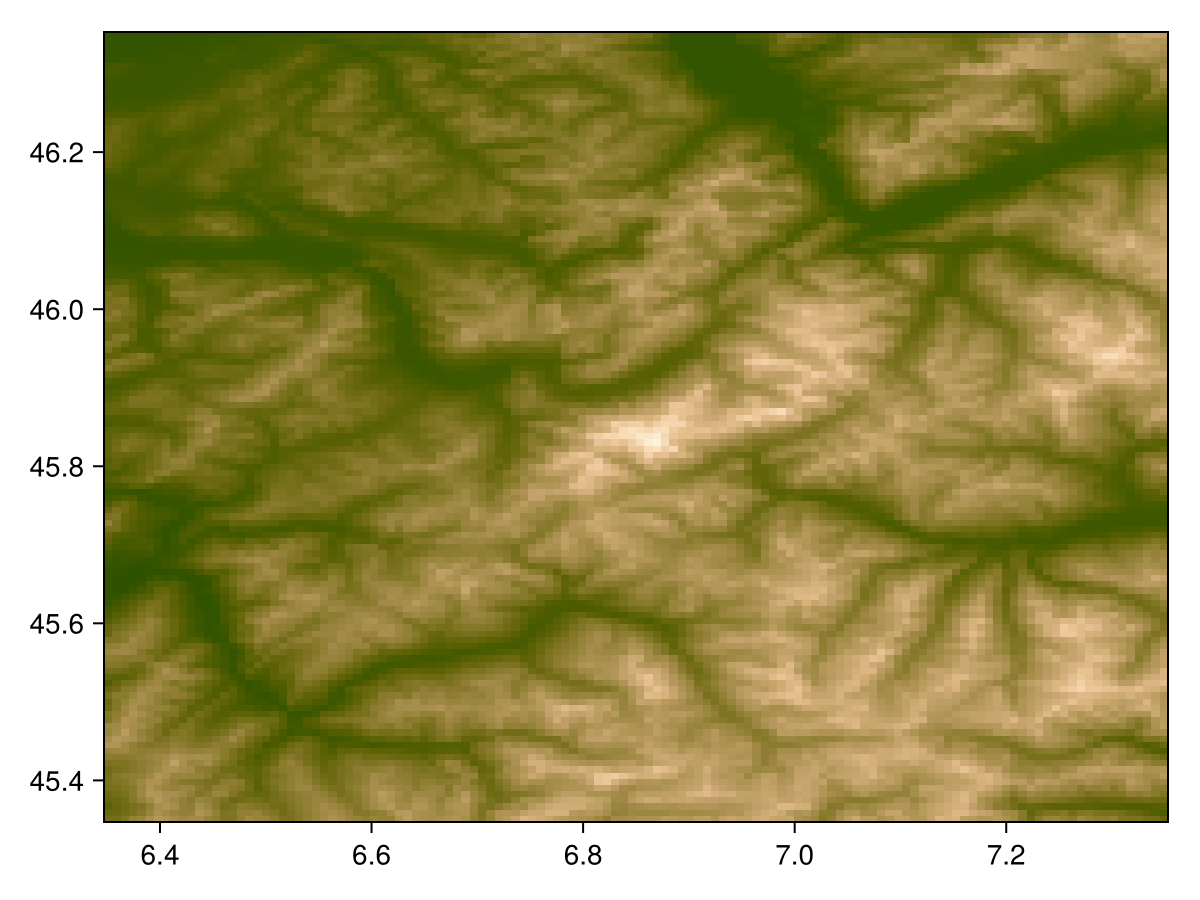

In [5]:
x = LinRange(6.351, 7.349, n)
y = LinRange(45.351, 46.349, n)
X = topography_GMT.lon.val[:, 1, 1], topography_GMT.lat.val[1, :, 1]
itp = interpolate(X, surf, Gridded(Linear()))
h   = [itp(x, y) * 1e3 for x in x, y in y]
heatmap(x, y, h, colormap=:oleron, colorrange=(-4810, 4810))

compute the x and y size of our cartesian model

In [6]:
lat_dist  = extrema(X[1]) |> collect |> diff |> first |> abs
long_dist = extrema(X[2]) |> collect |> diff |> first |> abs
Lx        = 1e3 * lat_dist * 110.574
Ly        = 1e3 * long_dist * 111.320 * cos(lat_dist)

60146.45268924132

and finally define the geometry again

In [7]:
x       = LinRange(0, Lx, n)
y       = LinRange(0, Ly, n)
dx      = x[2] - x[1]
dy      = y[2] - y[1]
X       = [x for x in x, y in y]
Y       = [y for x in x, y in y]

128×128 Matrix{Float64}:
 0.0  473.594  947.188  1420.78  …  58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78  …  58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672.9  60146.5
 ⋮                               ⋱               ⋮             
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78  …  58725.7  59199.3  59672.9  60146.5
 0.0  473.594  947.188  1420.78     58725.7  59199.3  59672

We only have to define a single constant physical paremeter, the hillslope diffusion coefficient

In [8]:
K   = 2.5 # [m^2/year]

2.5

Remember that the time stepping is now limiter by the CFL condition

In [9]:
C  = 0.1
dt = C * dx^2 / K # [yrs]

30322.052144584286

Taking a look at the equations, we only need three two-dimensional `Array`s to solve the explicit problem:

|     Array      |        size      |
|:--------------:|:----------------:|
| $\mathbf{h}$   | $n   \times n  $ |
| $\mathbf{q}_x$ | $n-1 \times n-2$ |
| $\mathbf{q}_y$ | $n-2 \times n-1$ |

where $n$ is the number of grid points. We have already created $\mathbf{h}$ as the initial topography profile `h`. We just need to allocate the fluxes $\mathbf{q}_x$ and $\mathbf{q}_y$

In [10]:
qx              = zeros(n-1, n-2)
qy              = zeros(n-2, n-1)
initial_profile = copy(h) # save initial profile for plotting purposes

128×128 Matrix{Float64}:
 1495.88  1350.18   1078.23   1280.72  …   394.048   391.726   423.24
 1505.41  1333.71   1283.16   1351.05      390.43    382.534   376.318
 1710.94  1468.35   1428.86   1470.31      391.937   385.05    370.0
 2035.78  1601.2    1570.45   1757.94      396.609   378.951   370.0
 2136.71  1790.52   1688.76   2075.5       393.03    377.308   370.0
 2433.34  2137.15   2026.14   2332.42  …   403.777   370.721   370.0
 2609.48  2450.36   2370.38   2619.87      421.739   386.15    376.274
 2486.22  2273.46   2474.66   2421.57      449.209   413.264   399.545
 2325.13  2099.79   2351.64   2225.52      442.606   416.52    420.256
 2210.85  2003.99   2008.0    2001.89      437.595   452.797   425.103
    ⋮                                  ⋱     ⋮                
 1904.13  1620.66   1068.4    1248.63     2241.76   2208.43   2092.27
 1864.85  1588.51   1035.28   1318.21  …  2285.93   2110.14   2107.64
 1960.38  1583.15    978.546  1289.74     2457.52   2299.83   2356.02
 

We now have all the objects needed to solve the hillslope diffusion equation, we just need to decide for how long we want to run the model and setup the time stepping

```julia
run_time = 1e6 # [yr]
t        = 0
nt       = 0
while t < run_time
    qx .= ??
    qy .= ??
    @views h[2:end-1, 2:end-1] .= ??
    nt += 1
    t  += dt
end
```

## Exercise
1. Define the missing functions `compute_flux` and `update_h` to compute the fluxes `q` and update `h`, respectively.
2. How much can we increase `C` before the model 🧨💥?

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*